<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/train_compare_full_data/chisti_ltsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
  <img alt="FINKI **LOGO**" height="30px" src="https://www.finki.ukim.mk/Content/dataImages/downloads/logo-large-500x500_2.png" hspace="10px" vspace="0px">
  Интелигентни системи - Лабораториска вежба 2 (Претпроцесирање)
</h1>
<center><h3><i>Група 5<i><h3></center>

---



In [1]:
#@title Монтирање на Google Drive податочниот систем
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title Инсталирање и вчитување на потребните библиотеки

# Библиотека за истражување, визуелизација и анализирање на човечки 
# неврофизиолошки податоци (EEG, sEEG и др)
!pip install mne 
!pip install termcolor

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
from termcolor import colored
import mne
from sklearn.decomposition import PCA, FastICA
import mne

     |████████████████████████████████| 6.6MB 670kB/s 


In [3]:
%tensorflow_version 1.12.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.12.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [4]:
!wget "https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py"
!mkdir saved_models

--2020-05-19 16:13:38--  https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18283 (18K) [text/plain]
Saving to: ‘EEGModels.py’

EEGModels.py        100%[===================>]  17.85K  --.-KB/s    in 0s      

2020-05-19 16:13:38 (82.5 MB/s) - ‘EEGModels.py’ saved [18283/18283]



In [5]:
!readlink -f ~/.keras/keras.json

/root/.keras/keras.json


In [117]:
#@title Fourier analysis
# Вчитување на податоците

from sklearn import metrics 
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
from EEGModels import EEGNet,ShallowConvNet
import scipy.io as sio
from scipy.fft import fft
from scipy import signal
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras import backend as K
from tensorflow import keras
K.set_image_data_format('channels_first')

print(open("/root/.keras/keras.json").read())

# Вчитување на податоците
data = loadmat('drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainData.mat')['trainData'] 
for i in range(1, 2):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    if i == 1 and j == 1: continue
    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainData.mat"
    temp = loadmat(full_path)['trainData'] 
    data = np.concatenate((data, temp), axis=2)

print(data.size)
print(data.shape)

# Вчитување на label-ите
labels_arr = np.empty(0)
for i in range(1, 2):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainLabels.txt"
    with open(full_path, "r") as file_labels:
      temp = file_labels.read().splitlines()
      temp = np.repeat(temp, 8*10)
      labels_arr = np.concatenate((labels_arr, temp))

print(labels_arr)
print(len(labels_arr))

# Вчитување на редоследот на светкање
events_arr = np.empty(0)
for i in range(1, 2):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainEvents.txt"
    with open(full_path, "r") as file_events:
      temp = file_events.read().splitlines()
      events_arr = np.concatenate((events_arr, temp))

# Вчитување на редоследот на објекти кои се target
targets_arr = np.empty(0)
for i in range(1, 2):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainTargets.txt"
    with open(full_path, "r") as file_targets:
      temp = file_targets.read().splitlines()
      targets_arr = np.concatenate((targets_arr, temp))


{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}
13440000
(8, 350, 4800)
['6' '6' '6' ... '3' '3' '3']
4800


In [95]:
data.shape


(8, 350, 4800)

In [129]:
#data = target_events_data_scaled
mne_array = np.swapaxes(data, 0, 2) # (епохa, канал, настан). 
mne_array = np.swapaxes(mne_array, 1, 2) # (епохa, канал, настан).
mne_array = mne_array.reshape(mne_array.shape[0],1, 8,350)
print(mne_array.shape)

(4800, 1, 8, 350)


In [130]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from EEGModels import EEGNet,ShallowConvNet,DeepConvNet
events_arr = events_arr.astype(np.int)
labels_arr = labels_arr.astype(np.int)
from tensorflow.keras.optimizers import Adam

#mne_array = data.reshape(2800, data.shape[-1])
#mne_array = np.swapaxes(mne_array,0,1)
X_train, X_test, y_train, y_test = train_test_split(mne_array, labels_arr-1, test_size=0.25, random_state=42)


model = DeepConvNet(nb_classes = 8, Chans = 8, Samples = 350)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer = Adam(0.003))
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)


#clf = RandomForestClassifier(max_depth=5)
#clf.fit(X_train, y_train)
#score = clf.score(X_test, y_test)
#print(score)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_batch_size=100
num_epochs=400
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, \
          validation_data=(X_test, y_test),callbacks=[checkpointer], verbose=1)

score = model.evaluate(X_test, y_test, verbose=1)
print(score)

#model = Sequential()
#model.add(Dense(2800, input_dim=2800), activation='relu')
#model.add(Dense(350, activation='sigmoid'))
#model.add(Dense(350, activation='sigmoid'))
#model.add(Dense(1, activation='sigmoid'))

#clf = svm.SVC()
#clf = RandomForestClassifier(random_state=0, n_estimators=350)
#clf = LinearDiscriminantAnalysis()
#clf.fit(X_train, y_train)

Train on 3600 samples, validate on 1200 samples
Epoch 1/400
3500/3600 [============================>.] - ETA: 0s - loss: 2.3496 - acc: 0.1786
Epoch 00001: val_loss improved from inf to 2.14333, saving model to saved_models/weights.best.basic_mlp.hdf5
3600/3600 [==============================] - 4s 1ms/sample - loss: 2.3426 - acc: 0.1786 - val_loss: 2.1433 - val_acc: 0.1175
Epoch 2/400
3400/3600 [===========================>..] - ETA: 0s - loss: 2.1659 - acc: 0.1832
Epoch 00002: val_loss did not improve from 2.14333
3600/3600 [==============================] - 1s 185us/sample - loss: 2.1665 - acc: 0.1808 - val_loss: 2.2743 - val_acc: 0.1000
Epoch 3/400
3300/3600 [==========================>...] - ETA: 0s - loss: 2.1431 - acc: 0.1852
Epoch 00003: val_loss did not improve from 2.14333
3600/3600 [==============================] - 1s 174us/sample - loss: 2.1398 - acc: 0.1864 - val_loss: 2.1487 - val_acc: 0.1308
Epoch 4/400
3200/3600 [=========================>....] - ETA: 0s - loss: 2.0876 

KeyboardInterrupt: ignored

In [162]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow import convert_to_tensor
np.random.seed(7)
embedding_vecor_length = 8
model = Sequential()
data_ltsm = np.swapaxes(data,0,1)
data_ltsm = convert_to_tensor(data_ltsm)
print(data_ltsm.shape)
model.add(LSTM(return_sequences=False,units= 8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_trainl, X_testl, y_trainl, y_testl = train_test_split(mne_array, labels_arr-1, test_size=0.25, random_state=42)
y_trainl = to_categorical(y_trainl)
y_testl = to_categorical(y_testl)
X_trainl=np.swapaxes(X_trainl,1,2)
X_testl=np.swapaxes(X_testl,1,2)
model.fit(X_trainl[:,:,:,0], y_trainl,epochs=400, batch_size=350)
#Final evaluation of the model
scores = model.evaluate(X_testl, y_testl, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

(350, 8, 4800)


ValueError: ignored

In [0]:
import seaborn as sns
sns.distplot(y_train);

In [0]:
score = clf.score(X_test, y_test)
print(score)

In [0]:


print(data.shape)
#mne_array = data.reshape([target_events_data.shape[2],1,8, 350])
print(mne_array.shape)
#stft = mne.time_frequency.stft(mne_array[0], 24)

# Number of sample points

FS = 250
N = 350
# sample spacing
T = 1.0 / FS
x = np.linspace(0.0, N*T, N)
num_labels= 8
#plt.plot(mne_array[2][2], np.linspace(0.0,N,N))

#fig, axs = plt.subplots(8,8, figsize=(4*8,4*8))
#freq_data = list()
#for i in range(8):
#  for x in range(8):
#    f, t, Sxx = signal.spectrogram(mne_array[x][i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)
#    freq_data.append(Sxx)
#    axs[i,x].pcolormesh(t, f, Sxx)
#plt.show()
#print(open("~/keras/keras.json").read())

#events_arr = list(map(int, events_arr))





#y_train = np.array(y_train)
#y_train = to_categorical(y_train)
#y_test = np.array(y_test)
#y_test = to_categorical(y_test)
# Construct model 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
num_epochs = 50
num_batch_size = 100

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(score)

#preds = model.predict(X_test, verbose=0)
#acc = accuracy_score(y_test, preds)

print("accuracy_score: {f}".format(f=score))


(8, 350, 100)
(8, 350, 200)


NameError: ignored

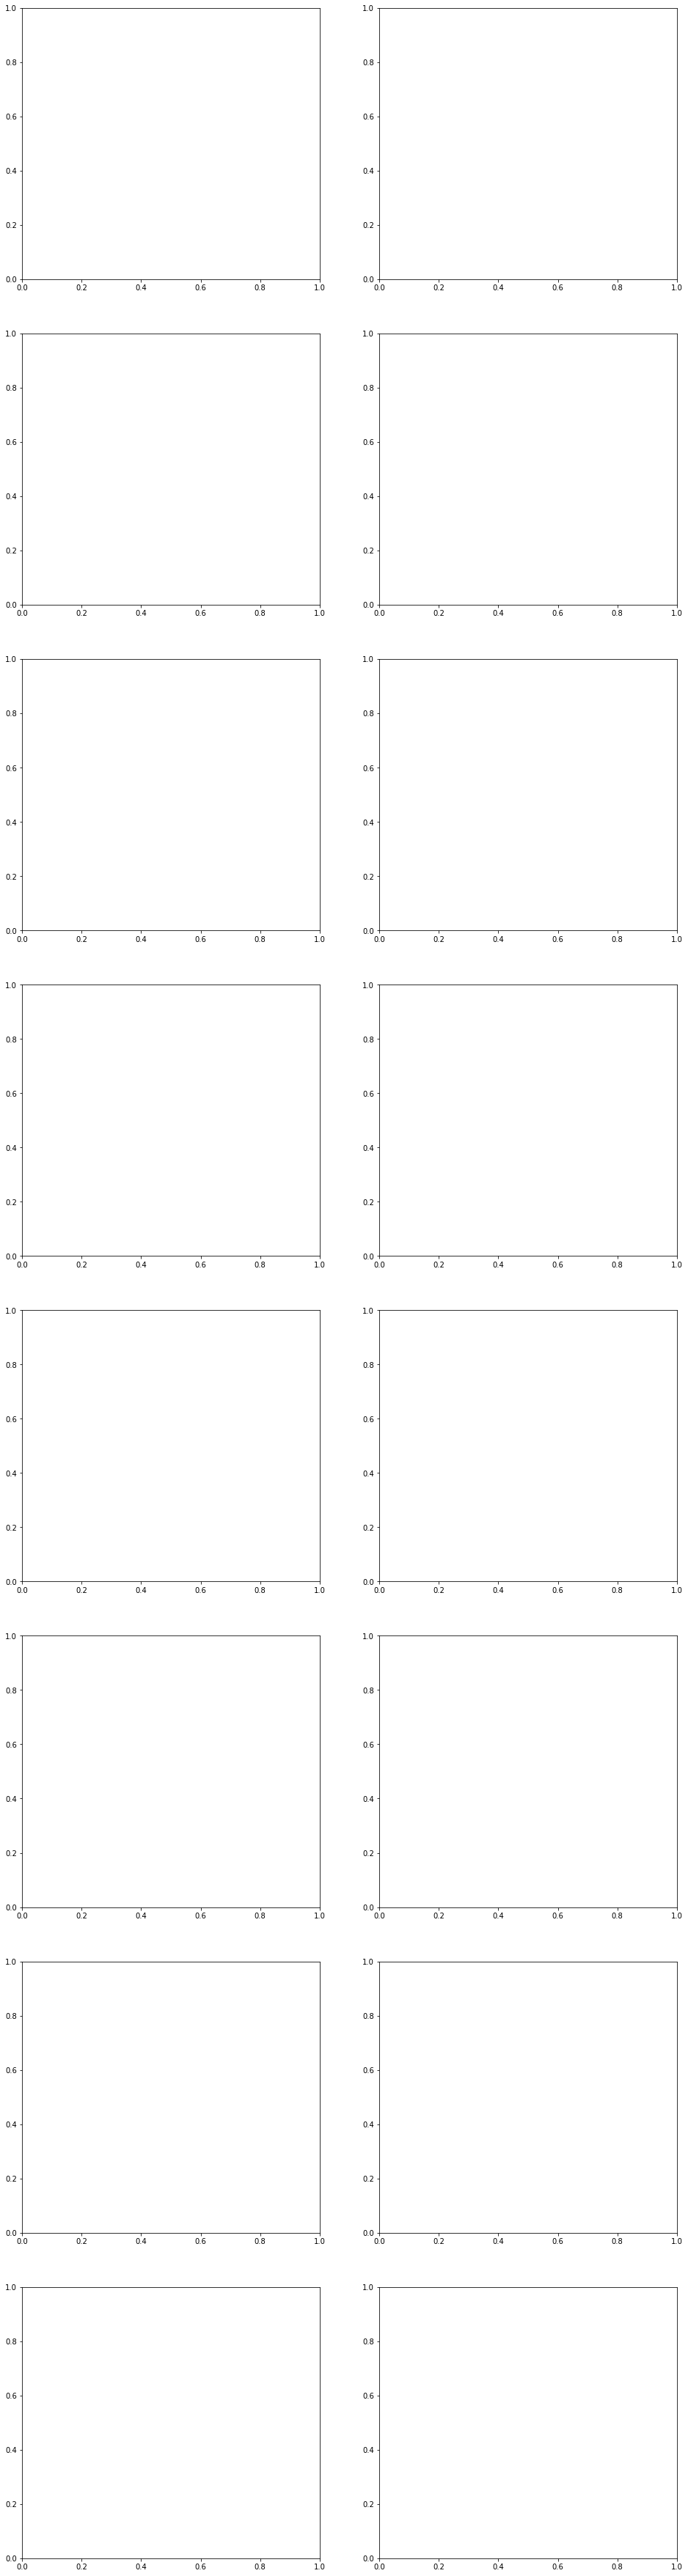

In [14]:
#@title 1st objest, target vs non target
# Вчитување на податоците
data = loadmat('drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainData.mat')['trainData'] 

# Вчитување на label-ите
labels_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainLabels.txt", "r") as file_labels:
    labels_arr = file_labels.read().splitlines()

# Вчитување на редоследот на светкање
events_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainEvents.txt", "r") as file_events:
    events_arr = file_events.read().splitlines()

# Вчитување на редоследот на објекти кои се target
targets_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainTargets.txt", "r") as file_targets:
    targets_arr = file_targets.read().splitlines()

# Прилагодување на податоците за користење со mne библиотеката
ch_names = ["C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"]
ch_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
mne_info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)
#mne_array = np.swapaxes(data, 0, 2) # (епохa, канал, настан). 
#mne_array = np.swapaxes(mne_array, 1, 2) # (епохa, канал, настан). 
#raw_data = mne.epochs.EpochsArray(mne_array, mne_info)

# Извлекување на настаните каде светнал првиот објект и бил target.
first_object_events_target = [index for index, value in enumerate(events_arr) if value == '1']
first_object_non_target = [index for index, value in enumerate(events_arr) if value == '1']

for event_pos in first_object_events_target:
  if targets_arr[event_pos] == 1:
    first_object_non_target.remove(event_pos)
    continue # Продолжи
  else:
    first_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
first_object_target_eeg_data = np.zeros((8,350, len(first_object_events_target)))
first_object_non_target_eeg_data = np.zeros((8,350, len(first_object_non_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events_target: # Настан
      first_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1
    
    k=0
    for event in first_object_non_target: # Настан
      first_object_non_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      k = k+1

print(first_object_target_eeg_data.shape)
print(first_object_non_target_eeg_data.shape)

first_object_target_eeg_data = np.mean(first_object_target_eeg_data, axis=2)
first_object_non_target_eeg_data = np.mean(first_object_non_target_eeg_data, axis=2)

fig, axs = plt.subplots(8,2,figsize=(16,16*4))
for i in range(8):
  f, t, Sxx = signal.spectrogram(first_object_target_eeg_data[i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)
  fnon, tnon, Sxxnon = signal.spectrogram(first_object_non_target_eeg_data[i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)

  axs[i,0].pcolormesh(t, f, Sxx)
  axs[i,1].pcolormesh(tnon, fnon, Sxxnon)
plt.show()

350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Computing rank from data with rank='full'
    EEG: rank 8 from info
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 8 from info
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 6 Xdawn components
Inverse transforming to sensor space
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


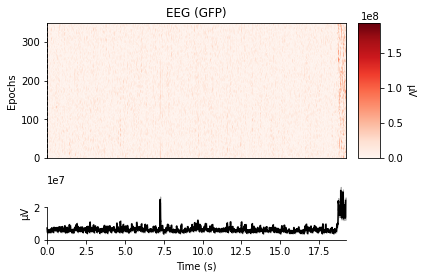

[<Figure size 432x288 with 3 Axes>]

In [55]:
ch_names = ["C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"]
ch_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
mne_info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)
mne_array_clean = np.swapaxes(data, 0, 1)
raw_data_clean = mne.epochs.EpochsArray(mne_array_clean, mne_info)
Min, Max = round(mne_array_clean.min()),round(mne_array_clean.max())*1000000
picks = mne.pick_types(raw_data_clean.info, meg=False, eeg=True, stim=False, eog=False)
xd = mne.preprocessing.Xdawn(n_components=2, signal_cov=None)
xd.fit(raw_data_clean)
epochs_denoised = xd.apply(raw_data_clean)
epochs_denoised.keys()
mne.viz.plot_epochs_image(epochs_denoised['1'], picks='eeg', vmin=Min, vmax=Max)

In [64]:
array_test=np.swapaxes(epochs_denoised['1'],0,0)
array_test=np.swapaxes(array_test,0,2)
array_test=array_test.reshape(array_test.shape[0],1,8,350)
print(array_test.shape)

(4800, 1, 8, 350)


In [70]:
print(np.swapaxes(epochs_denoised['1'],0,0).shape)
standardizer = mne.decoding.Scaler(scalings='mean')
standardizer.fit(np.swapaxes(epochs_denoised['1'],0,0))
standardized_data = standardizer.transform(np.swapaxes(epochs_denoised['1'],0,0))
print(standardized_data.shape)


(350, 8, 4800)
(350, 8, 4800)


In [79]:
standardizer = mne.decoding.Scaler(scalings='mean')
#print(np.swapaxes(data,0,1).shape)
standardizer.fit(data)
standardized_data = standardizer.transform(data)
print(standardized_data.shape)
mne_array = np.swapaxes(standardized_data, 0, 2) # (епохa, канал, настан). 
mne_array = np.swapaxes(mne_array, 1, 2) # (епохa, канал, настан).
mne_array = mne_array.reshape(mne_array.shape[0],1, 8,350)
print(mne_array.shape)

(8, 350, 4800)
(4800, 1, 8, 350)


In [57]:
standardized_data.shape
standardized_data=np.swapaxes(standardized_data,0,2)
standardized_data=standardized_data.reshape(standardized_data.shape[0],1,8,350)
print(standardized_data.shape)

(4800, 1, 8, 350)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(mne_array, labels_arr-1, test_size=0.25, random_state=42)


model = DeepConvNet(nb_classes = 8, Chans = 8, Samples = 350)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer = Adam(0.003))
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)


#clf = RandomForestClassifier(max_depth=5)
#clf.fit(X_train, y_train)
#score = clf.score(X_test, y_test)
#print(score)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_batch_size=100
num_epochs=400
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, \
          validation_data=(X_test, y_test),callbacks=[checkpointer], verbose=1)

score = model.evaluate(X_test, y_test, verbose=1)
print(score)


Train on 3600 samples, validate on 1200 samples
Epoch 1/400
3500/3600 [============================>.] - ETA: 0s - loss: 2.4846 - acc: 0.1717
Epoch 00001: val_loss improved from inf to 2.58751, saving model to saved_models/weights.best.basic_mlp.hdf5
3600/3600 [==============================] - 3s 726us/sample - loss: 2.4772 - acc: 0.1733 - val_loss: 2.5875 - val_acc: 0.1058
Epoch 2/400
3300/3600 [==========================>...] - ETA: 0s - loss: 2.2323 - acc: 0.1764
Epoch 00002: val_loss improved from 2.58751 to 2.12061, saving model to saved_models/weights.best.basic_mlp.hdf5
3600/3600 [==============================] - 1s 183us/sample - loss: 2.2270 - acc: 0.1767 - val_loss: 2.1206 - val_acc: 0.1750
Epoch 3/400
3300/3600 [==========================>...] - ETA: 0s - loss: 2.2768 - acc: 0.1639
Epoch 00003: val_loss did not improve from 2.12061
3600/3600 [==============================] - 1s 168us/sample - loss: 2.2611 - acc: 0.1672 - val_loss: 2.1614 - val_acc: 0.2067
Epoch 4/400
3300

In [0]:
FS = 250
N = 350
# sample spacing
T = 1.0 / FS
x = np.linspace(0.0, N*T, N)
num_labels= 8
#plt.plot(mne_array[2][2], np.linspace(0.0,N,N))

#fig, axs = plt.subplots(8,8, figsize=(4*8,4*8))
#freq_data = list()
#for i in range(8):
#  for x in range(8):
#    f, t, Sxx = signal.spectrogram(mne_array[x][i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)
#    freq_data.append(Sxx)
#    axs[i,x].pcolormesh(t, f, Sxx)
#plt.show()
#print(open("~/keras/keras.json").read())

#events_arr = list(map(int, events_arr))
standardized_data_eeg = np.swapaxes(standardized_data,0,2)
standardized_data_eeg=standardized_data_eeg.reshape([1600,1,8, 350])
X_train, X_test, y_train, y_test = train_test_split(standardized_data_eeg, events_arr, test_size=0.33, random_state=42)
#y_train = np.array(y_train)
y_train = to_categorical(y_train)
#y_test = np.array(y_test)
y_test = to_categorical(y_test)
# Construct model 


num_epochs = 50
num_batch_size = 10

model = EEGNet(nb_classes = 9, Chans = 8, Samples = 350)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer = 'adam')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, \
          validation_data=(X_test, y_test),callbacks=[checkpointer], verbose=1)

score = model.evaluate(X_test, y_test, verbose=1)
#preds = model.predict(X_test, verbose=0)
#acc = accuracy_score(y_test, preds)

print("accuracy_score: {f}".format(f=score))
